Show differences in SST between old baseline (used in Bretherton et al. 2022, JAMES) and the new baseline with SSTs specified to be equal to fine-res.

In [1]:
import xarray as xr
import fsspec
import fv3viz
import vcm
from vcm.catalog import catalog
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [2]:
mask = catalog['landseamask/c48'].to_dask().load()
grid = catalog['grid/c48'].to_dask().load()

In [3]:
urls = {
    'n2f-baseline': 'gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805-start-rad-step-1800s',
    'new-baseline': 'gs://vcm-ml-experiments/default/2022-11-21/ml-on-fine-baseline-long-trial-0/fv3gfs_run',
}
variables = ['surface_temperature']

In [4]:
ds = []
for name, url in urls.items():
    tmp = xr.open_zarr(fsspec.get_mapper(url + '/state_after_timestep.zarr'))
    ds.append(tmp[variables].assign_coords(run=name))
ds = xr.concat(ds, dim='run', join='inner')
diff = ds.isel(run=1) - ds.isel(run=0)
ds = xr.merge([ds, grid])
diff = xr.merge([diff, grid])

In [5]:
diff['ocean_surface_temperature'] = diff.surface_temperature.where(mask.land_sea_mask == 0)

In [6]:
diff_mean = diff.mean('time').compute()

(<Figure size 1950x450 with 5 Axes>,
 array([[<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7fe8445973d0>,
       dtype=object),
 <xarray.plot.facetgrid.FacetGrid at 0x7fe848305e80>)

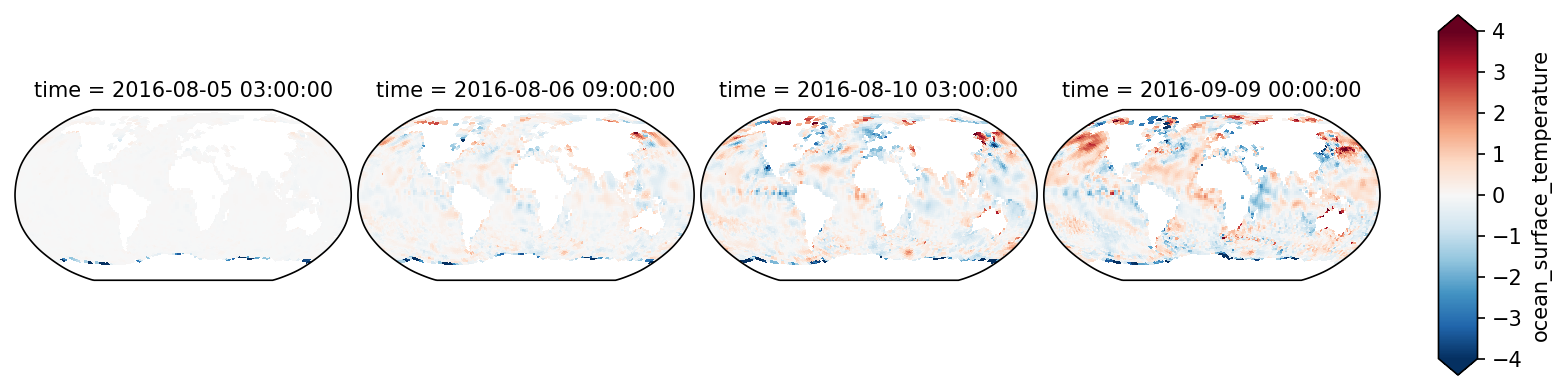

In [7]:
fv3viz.plot_cube(diff.isel(time=[0, 10, 40, -1]), 'ocean_surface_temperature', col='time', vmin=-4, vmax=4, coastlines=False);

(<Figure size 900x600 with 1 Axes>,
 array(<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7fe8440705b0>,
       dtype=object),
 None)

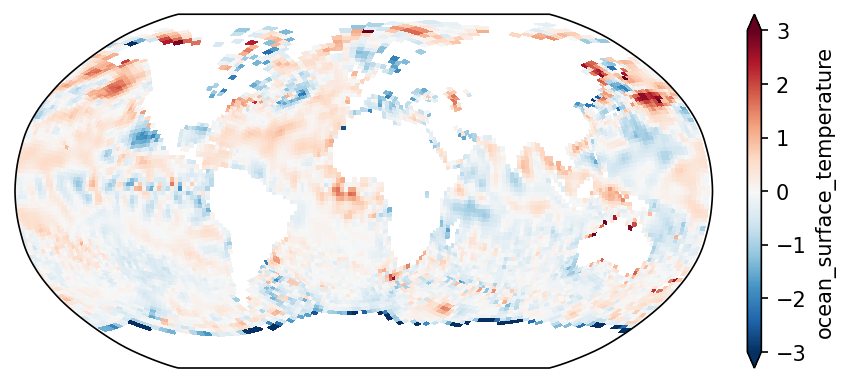

In [8]:
fv3viz.plot_cube(diff_mean, 'ocean_surface_temperature', vmin=-3, vmax=3, coastlines=False);

In [9]:
weights = grid.area.where(mask.land_sea_mask == 0)
vcm.weighted_average(diff_mean['surface_temperature'], weights)

<xarray.DataArray 'surface_temperature' ()>
array(-0.01535858)

In [10]:
vcm.weighted_average(abs(diff_mean.surface_temperature), weights)

<xarray.DataArray 'surface_temperature' ()>
array(0.35815671)